## MURA dataset pre-processing for Machine Learning
This notebook does the following things:

* 1. **Read** the images from the dataset.
* 2. **Match** the data and the label.(Along with human part, patient number, study number, etc)
* 3. **Transfer** the images into gray (RGB channels to 1 channel).
* 4. **Reshape** the images to a standard size (here, $128\times 128$) and then do the **standardization** and **edge detection** (sobel operation) and **histogram equalization**.
* 5. The final image vector will be shaped as: $1\times(128*128)$
* 6. Perform **PCA**

<h1 style="text-align:right">$\mathcal{ZLF}$ </h1>

## 1. Read the images

In [1]:
# import packages
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
from skimage.transform import resize
from PIL import Image
from skimage.filters import sobel
from scipy import ndimage

%matplotlib inline

In [2]:
# get the data paths (and labels)
train_img_path = pd.read_csv("train_image_paths.csv", header=None)
# train_img_label = pd.read_csv("train_labeled_studies.csv", header=None)
valid_img_path = pd.read_csv("valid_image_paths.csv", header=None)
# valid_img_label = pd.read_csv("valid_labeled_studies.csv", header=None)

In [3]:
# show the data
train_img_path.head()

,0
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...


## 2. Add labels to the data

In [4]:
# add labels to the data sets
redundant_prefix = 'MURA-v1.1/'    ##preparing labels
len_prefix = len(redundant_prefix) # len_prefix = 10

train_img_path['Path2Img'] = train_img_path[0].apply(lambda x: x[len_prefix:])
valid_img_path['Path2Img'] = valid_img_path[0].apply(lambda x: x[len_prefix:])

def extract_label(string, d):
    """
    extract labels "positive/negative" from file path
    """
    try:
        pre_str = os.path.splitext(string)[0]
        label = pre_str.split("/")[-2].split("_")[-1]
        if np.isin(label, list(d.keys())):
            return(d[label])
        else:
            return('No corresponding key value')
    except IOError:
        return(np.nan)

d = {'positive':1, 'negative':0}

train_img_path['label'] = train_img_path[0].apply(lambda x: extract_label(x, d=d))
valid_img_path['label'] = valid_img_path[0].apply(lambda x: extract_label(x, d=d))

In [5]:
train_img_path.head()

,0,Path2Img,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,train/XR_SHOULDER/patient00001/study1_positive...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,train/XR_SHOULDER/patient00001/study1_positive...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,train/XR_SHOULDER/patient00001/study1_positive...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,train/XR_SHOULDER/patient00002/study1_positive...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,train/XR_SHOULDER/patient00002/study1_positive...,1


In [6]:
train_img_path.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36808 entries, 0 to 36807
Data columns (total 3 columns):
0           36808 non-null object
Path2Img    36808 non-null object
label       36808 non-null int64
dtypes: int64(1), object(2)
memory usage: 862.8+ KB


In [7]:
valid_img_path.head()

,0,Path2Img,label
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,valid/XR_WRIST/patient11185/study1_positive/im...,1
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,valid/XR_WRIST/patient11185/study1_positive/im...,1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,valid/XR_WRIST/patient11185/study1_positive/im...,1
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,valid/XR_WRIST/patient11185/study1_positive/im...,1
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,valid/XR_WRIST/patient11186/study1_positive/im...,1


In [8]:
valid_img_path.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3197 entries, 0 to 3196
Data columns (total 3 columns):
0           3197 non-null object
Path2Img    3197 non-null object
label       3197 non-null int64
dtypes: int64(1), object(2)
memory usage: 75.0+ KB


## 3. Transfer to gray & Resize & Standardization & Edge detection & Histogram Equalization

In [9]:
#From here, prepare images to 1-D arrays
img_size = (128, 128) ##size of images, can be modified

# transfer to gray: In fact, we just use cv2.imread(path, 0) function to get grayscale img instead of this function
def identify_tranfer2gray(raw_image_tensor, ratio = [0.299, 0.587, 0.114]):##ratio can be modified, but be sure the sum is 1.!
    """
    Identify images' color status, if it is gray-valued, no action, otherwise transform colorful images to gray-valued images.
    ---------
    Input: 
    param path: A tensor, from desired image
    param ratio: A list, ratio of merging gray value image from a RGB image
    ---------
    Output: A matrix, of size height*width from raw image
    """
    if len(raw_image_tensor.shape)==3: # if the input is 3 dimensional tensor
        return(np.dot(raw_image_tensor[...,:3], ratio))
    else:
        return(raw_image_tensor)
    
# Resize and standardization and edge detection:
def read_resize(path, rescale = img_size, sobel_op = False, hist = False, *args, **kwargs): 
    """
    Dealing gray-value images(i.e. no color)
    Read images from file path, and rescale it according to provided image size
    ---------
    Input:
    param path: A string, path to image
    param rescale: A tuple, new size of image
    sobel_op: If true, perform Sobel Operation
    hist: If true, perform Histogram Equalization
    ---------
    Output: 
    row vector of size (1, new_height*new_width)
    """
    raw_img_tensor = cv2.imread(path, 0) # load img as grayscale
    
    if hist:
        img_tensor = cv2.equalizeHist(raw_img_tensor)
    else:
        img_tensor = raw_img_tensor
        
    if sobel_op:
        img_tensor = sobel(img_tensor)
    else:
        img_tensor = img_tensor
    
    # Notice that "resize" function do the standardization(divided by 255) automatically
    rescale_image_tensor = resize(img_tensor, output_shape=rescale, mode = 'constant') 
    try:
        rescale_image_vector = np.reshape(rescale_image_tensor, newshape=(1, rescale[0]*rescale[1]))
        return(np.squeeze(rescale_image_vector))
    except IOError:
        return(np.nan)

In [10]:
train_img_path['img_vector'] = train_img_path['Path2Img'].apply(lambda x: read_resize(x)) #images have been normalized
train_img_path.head()

,0,Path2Img,label,img_vector
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,train/XR_SHOULDER/patient00001/study1_positive...,1,"[0.029963235294117648, 0.02558210784313726, 0...."
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,train/XR_SHOULDER/patient00001/study1_positive...,1,"[0.0, 0.0, 0.0, 0.0, 0.5783930759803888, 0.602..."
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,train/XR_SHOULDER/patient00001/study1_positive...,1,"[0.2505514705882314, 0.23469669117647024, 0.22..."
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,train/XR_SHOULDER/patient00002/study1_positive...,1,"[0.23529411764705882, 0.23048406862745144, 0.2..."
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,train/XR_SHOULDER/patient00002/study1_positive...,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.24705882352941438,..."


In [11]:
valid_img_path['img_vector'] = valid_img_path['Path2Img'].apply(lambda x: read_resize(x)) #images have been normalized
valid_img_path.head()

,0,Path2Img,label,img_vector
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,valid/XR_WRIST/patient11185/study1_positive/im...,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,valid/XR_WRIST/patient11185/study1_positive/im...,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,valid/XR_WRIST/patient11185/study1_positive/im...,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,valid/XR_WRIST/patient11185/study1_positive/im...,1,"[0.9109451593137268, 0.3222886029411781, 0.235..."
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,valid/XR_WRIST/patient11186/study1_positive/im...,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## 4. Other info

In [12]:
###Prepare other labels that may be helpful
train_img_path.drop(labels=0, axis=1,inplace=True) #drop redundant column
valid_img_path.drop(labels=0, axis=1,inplace=True) #drop redundant column


def human_part(path):
    expected_output = path.split('/')[1].split("_")[1]
    return(expected_output)

def patient_number(path):
    expected_output = path.split('/')[2][-5:]
    try:
        expected_output = np.int(expected_output)
        return(expected_output)
    except IOError:
        return(np.nan)

def study_number(path):
    expected_output = path.split('/')[3].split("_")[0][-1]
    try:
        expected_output = np.int(expected_output)
        return(expected_output)
    except IOError:
        return(np.nan)

train_img_path['human_part'] = train_img_path['Path2Img'].apply(lambda x: human_part(x))
train_img_path['patient_number'] = train_img_path['Path2Img'].apply(lambda x: patient_number(x))
train_img_path['study_number'] = train_img_path['Path2Img'].apply(lambda x: study_number(x))

valid_img_path['human_part'] = valid_img_path['Path2Img'].apply(lambda x: human_part(x))
valid_img_path['patient_number'] = valid_img_path['Path2Img'].apply(lambda x: patient_number(x))
valid_img_path['study_number'] = valid_img_path['Path2Img'].apply(lambda x: study_number(x))

In [13]:
# show final data structure
train_img_path.head()

,Path2Img,label,img_vector,human_part,patient_number,study_number
0,train/XR_SHOULDER/patient00001/study1_positive...,1,"[0.029963235294117648, 0.02558210784313726, 0....",SHOULDER,1,1
1,train/XR_SHOULDER/patient00001/study1_positive...,1,"[0.0, 0.0, 0.0, 0.0, 0.5783930759803888, 0.602...",SHOULDER,1,1
2,train/XR_SHOULDER/patient00001/study1_positive...,1,"[0.2505514705882314, 0.23469669117647024, 0.22...",SHOULDER,1,1
3,train/XR_SHOULDER/patient00002/study1_positive...,1,"[0.23529411764705882, 0.23048406862745144, 0.2...",SHOULDER,2,1
4,train/XR_SHOULDER/patient00002/study1_positive...,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.24705882352941438,...",SHOULDER,2,1


In [14]:
# show final data structure
valid_img_path.tail()

,Path2Img,label,img_vector,human_part,patient_number,study_number
3192,valid/XR_FINGER/patient11967/study1_negative/i...,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",FINGER,11967,1
3193,valid/XR_FINGER/patient11967/study1_negative/i...,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",FINGER,11967,1
3194,valid/XR_FINGER/patient11738/study1_negative/i...,0,"[0.008180147058823084, 0.009803921568627447, 0...",FINGER,11738,1
3195,valid/XR_FINGER/patient11738/study1_negative/i...,0,"[0.011764705882352941, 0.011764705882352941, 0...",FINGER,11738,1
3196,valid/XR_FINGER/patient11738/study1_negative/i...,0,"[0.011764705882352941, 0.011764705882352941, 0...",FINGER,11738,1


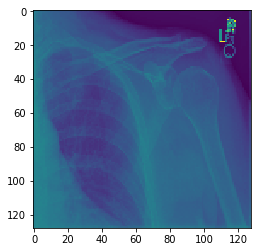

In [15]:
###Showing an image, paint it as you like(by modifying ratio!!!!)
plt.imshow(train_img_path['img_vector'][77].reshape(img_size[0], img_size[1]));

## 5. Obtain the whole dataset

In [16]:
# concat the train and valid data
data = pd.concat([train_img_path, valid_img_path], ignore_index=True)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40005 entries, 0 to 40004
Data columns (total 6 columns):
Path2Img          40005 non-null object
label             40005 non-null int64
img_vector        40005 non-null object
human_part        40005 non-null object
patient_number    40005 non-null int64
study_number      40005 non-null int64
dtypes: int64(3), object(3)
memory usage: 1.8+ MB


In [18]:
# split the data
elbow = data[data['human_part'] == 'ELBOW']
finger = data[data['human_part'] == 'FINGER']
forearm = data[data['human_part'] == 'FOREARM']
hand = data[data['human_part'] == 'HAND']
humerus = data[data['human_part'] == 'HUMERUS']
shoulder = data[data['human_part'] == 'SHOULDER']
wrist = data[data['human_part'] == 'WRIST']

## 6.1 Split and PCA for specific dataset

In [19]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

def my_split_PCA(data, img_size, num_of_components):
    # obtain the data
    quene = list()
    for j in range(len(data)):
        for i in data['img_vector'].values[j]:
            quene.append(i)
        
    X = np.array(quene).reshape(len(data), img_size[0]*img_size[1])
    y = data['label']
    
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.1,
                                                    random_state = 123,
                                                    shuffle = True,
                                                    stratify = y)
    
    # perform PCA on train set
    pca = PCA(n_components=num_of_components)
    
    # train the PCA
    pca_result_train = pca.fit_transform(X_train)
    pca_feature_cols = ['pca' + str(i) for i in range(1,pca_result_train.shape[1]+1)]
    pca_train_data = pd.DataFrame(pca_result_train, columns=pca_feature_cols)
    pca_train_data['label'] = y_train.values
    
    # perform the same PCA on the test set
    pca_result_test = pca.transform(X_test)
    pca_test_data = pd.DataFrame(pca_result_test, columns=pca_feature_cols)
    pca_test_data['label'] = y_test.values
    
    # print PCA exlained variance ratio
    print('PCA exlained variance ratio:', pca.explained_variance_ratio_)
    print('Total PCA exlained variance ratio:', np.sum(pca.explained_variance_ratio_))
    
    return pca_train_data, pca_test_data

In [20]:
# perform PCA and save the data
elbow_train, elbow_test = my_split_PCA(elbow, img_size = (128, 128), num_of_components = 0.8)
elbow_train.to_csv('elbow_train.csv')
elbow_test.to_csv('elbow_test.csv')
finger_train, finger_test = my_split_PCA(finger, img_size = (128, 128), num_of_components = 0.8)
finger_train.to_csv('finger_train.csv')
finger_test.to_csv('finger_test.csv')
forearm_train, forearm_test = my_split_PCA(forearm, img_size = (128, 128), num_of_components = 0.8)
forearm_train.to_csv('forearm_train.csv')
forearm_test.to_csv('forearm_test.csv')
hand_train, hand_test = my_split_PCA(hand, img_size = (128, 128), num_of_components = 0.8)
hand_train.to_csv('hand_train.csv')
hand_test.to_csv('hand_test.csv')
humerus_train, humerus_test = my_split_PCA(humerus, img_size = (128, 128), num_of_components = 0.8)
humerus_train.to_csv('humerus_train.csv')
humerus_test.to_csv('humerus_test.csv')
shoulder_train, shoulder_test = my_split_PCA(shoulder, img_size = (128, 128), num_of_components = 0.8)
shoulder_train.to_csv('shoulder_train.csv')
shoulder_test.to_csv('shoulder_test.csv')
wrist_train, wrist_test = my_split_PCA(wrist, img_size = (128, 128), num_of_components = 0.8)
wrist_train.to_csv('wrist_train.csv')
wrist_test.to_csv('wrist_test.csv')

PCA exlained variance ratio: [0.45390224 0.09827824 0.04605075 0.03915164 0.01966307 0.01491699
 0.01327631 0.010901   0.00915857 0.00807193 0.00730252 0.0070888
 0.00615086 0.00551449 0.00515707 0.00497019 0.00441562 0.00431964
 0.00412953 0.0037978  0.00361363 0.00327437 0.00316137 0.0030845
 0.00285027 0.00273822 0.0026296  0.00246935 0.0024552  0.00234124
 0.00224894 0.00221325 0.0021344 ]
Total PCA exlained variance ratio: 0.801431592757892
PCA exlained variance ratio: [0.45920358 0.12627123 0.06358521 0.05107016 0.03688602 0.02248308
 0.01923819 0.01511988 0.01271654]
Total PCA exlained variance ratio: 0.8065738821311438
PCA exlained variance ratio: [0.52021539 0.13279445 0.07711021 0.0397371  0.02521491 0.02107798]
Total PCA exlained variance ratio: 0.8161500520134529
PCA exlained variance ratio: [0.4620945  0.0839683  0.04641427 0.03738188 0.02680327 0.01988557
 0.01530073 0.01203681 0.00966335 0.00849568 0.0080824  0.00729892
 0.0068095  0.00639818 0.00526215 0.00506565 0.0048

## 6.2 Split and PCA for the whole dataset

In [21]:
# split the data into train and test
from sklearn.model_selection import train_test_split
def my_split(data, img_size, test_size):
    # obtain the data
    quene = list()
    for j in range(len(data)):
        for i in data['img_vector'].values[j]:
            quene.append(i)
        
    X = np.array(quene).reshape(len(data), img_size[0]*img_size[1])
    y = data['label']
    
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = test_size,
                                                    random_state = 123,
                                                    shuffle = True,
                                                    stratify = y)
    return X_train, X_test, y_train, y_test

In [22]:
from sklearn.decomposition import PCA
def my_PCA(X_train, X_test, y_train, y_test, num_of_components):
    # perform PCA on train set
    pca = PCA(n_components=num_of_components)
    
    # train the PCA
    pca_result_train = pca.fit_transform(X_train)
    pca_feature_cols = ['pca' + str(i) for i in range(1,pca_result_train.shape[1]+1)]
    pca_train_data = pd.DataFrame(pca_result_train, columns=pca_feature_cols)
    pca_train_data['label'] = y_train.values
    
    # perform the same PCA on the test set
    pca_result_test = pca.transform(X_test)
    pca_test_data = pd.DataFrame(pca_result_test, columns=pca_feature_cols)
    pca_test_data['label'] = y_test.values
    
    # print PCA exlained variance ratio
    print('PCA exlained variance ratio:', pca.explained_variance_ratio_)
    print('Total PCA exlained variance ratio:', np.sum(pca.explained_variance_ratio_))
    
    return pca_train_data, pca_test_data

In [23]:
# since the data is too big, we take the data apart
data1 = data.iloc[0:10000,:]
data2 = data.iloc[10000:20000,:]
data3 = data.iloc[20000:30000,:]
data4 = data.iloc[30000:40005,:]

In [24]:
X_train1, X_test1, y_train1,y_test1 = my_split(data1, img_size=(128,128), test_size=0.1)

In [25]:
X_train2, X_test2, y_train2,y_test2 = my_split(data2, img_size=(128,128), test_size=0.1)

In [26]:
X_train3, X_test3, y_train3,y_test3 = my_split(data3, img_size=(128,128), test_size=0.1)

In [27]:
X_train4, X_test4, y_train4,y_test4 = my_split(data4, img_size=(128,128), test_size=0.1)

In [28]:
X_train = np.concatenate((X_train1, X_train2, X_train3, X_train4))

In [29]:
X_test = np.concatenate((X_test1, X_test2, X_test3, X_test4))

In [30]:
y_train = pd.concat((y_train1, y_train2, y_train3, y_train4))

In [31]:
y_test = pd.concat((y_test1, y_test2, y_test3, y_test4))

In [32]:
# perform PCA
whole_train, whole_test = my_PCA(X_train, X_test, y_train, y_test, num_of_components=0.8)

MemoryError: 

In [ ]:
# save the data
whole_train.to_csv('whole_train.csv')
whole_test.to_csv('whole_test.csv')

## <center>$\mathcal{FIN}$</center>